# Find Outliers in MNIST
Build an MLP auto encoder and find the outliers based on the MSE reconstruction error.

## Imports and data

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [3]:
#get data without labels
(train_data, _), (test_data, _) = mnist.load_data()

## Task I: build MLP AE
* give latenspace size as hyper-parameter
* use MSE reconstruction loss

In [17]:
# This is the size of our encoded representations
# https://blog.keras.io/building-autoencoders-in-keras.html
latentspace_size = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = layers.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(latentspace_size, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [5]:
# This model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [18]:
# This is our encoded (32-dimensional) input
encoded_input = layers.Input(shape=(latentspace_size,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [7]:
autoencoder.compile(optimizer='adam', loss='mse')

## Task II: compute reconstrucion loss 
* of all train images
* plot loss distribution
* find threshold for outliers

In [8]:
x_train = train_data.astype('float32') / 255.
x_test = test_data.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [9]:
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 1s 2ms/step - loss: 0.0703 - val_loss: 0.0409
Epoch 2/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0295
Epoch 3/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0227
Epoch 4/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0187
Epoch 5/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0177 - val_loss: 0.0160
Epoch 6/50
235/235 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0141
Epoch 7/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0128
Epoch 8/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0119
Epoch 9/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 10/50
235/235 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0109

In [10]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


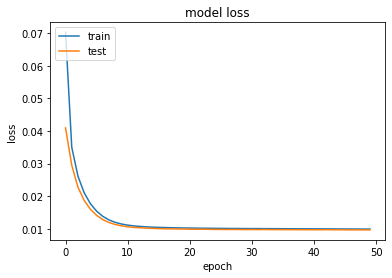

In [11]:
# summarize history for loss
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

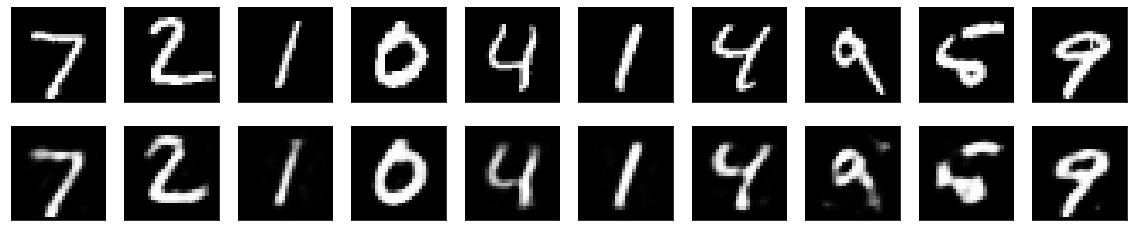

In [13]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [21]:
# reconstruction errors
errors = []
# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(images, decoded_imgs):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)

In [35]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, 0.998)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

[INFO] mse threshold: 0.03470797516405585
[INFO] 20 outliers found


## Task III: visualize top 20 outliers


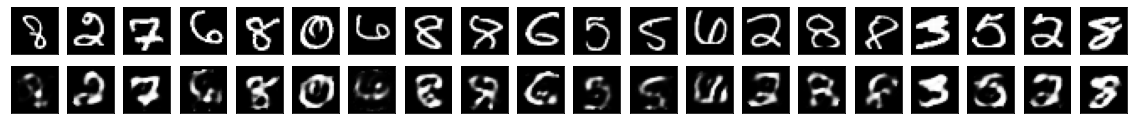

In [40]:
n = 20  # How many digits we will display
plt.figure(figsize=(20, 2))

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[idxs[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[idxs[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## References

* Autoencoder Feature Extraction for Classification: https://machinelearningmastery.com/autoencoder-for-classification/
* Building Autoencoders in Keras: https://blog.keras.io/building-autoencoders-in-keras.html
* Anomaly detection with Keras, TensorFlow, and Deep Learning: https://www.pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/